### Importing the libraries:

In [151]:
import pandas as pd
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf 

### Importing the Dataset:

In [152]:
data = pd.read_excel("Airlines+Data.xlsx")
data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


### Preprocessing the data:

In [153]:
# Adding t and t_square columns
t = [x for x in range(1,len(data.Passengers)+1)]
t_square = [x*x for x in t]
data["t"] = t
data["t_square"] = t_square
data

,Month,Passengers,t,t_square
0,1995-01-01,112,1,1
1,1995-02-01,118,2,4
2,1995-03-01,132,3,9
3,1995-04-01,129,4,16
4,1995-05-01,121,5,25
...,...,...,...,...
91,2002-08-01,405,92,8464
92,2002-09-01,355,93,8649
93,2002-10-01,306,94,8836
94,2002-11-01,271,95,9025


In [154]:
# Adding month column
data["month"] = data.Month.dt.strftime("%b")
data
months = [x[0] for x in data.iloc[0:12,4:5].values]

In [155]:
dummies = pd.get_dummies(data.month, columns=months)

In [156]:
dummies

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,1,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,1
93,0,0,0,0,0,0,0,0,0,0,1,0
94,0,0,0,0,0,0,0,0,0,1,0,0


#### We took dummies of the 12 months for the model building`

In [157]:
for month in months:
    data[month] = dummies[month]
    
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,5,25,May,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,0,0,0,0,1,0,0
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,0,0,0,0,0,1,0


In [158]:
data["Date"] = pd.to_datetime(data.Month,format="%b-%y")
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Date
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,0,0,0,0,0,0,0,1995-01-01
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,0,0,0,0,0,0,0,1995-02-01
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,0,0,0,0,0,0,0,1995-03-01
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,0,0,0,0,0,0,0,1995-04-01
4,1995-05-01,121,5,25,May,0,0,0,0,1,0,0,0,0,0,0,0,1995-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,0,0,1,0,0,0,0,2002-08-01
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,0,0,0,1,0,0,0,2002-09-01
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,0,0,0,0,1,0,0,2002-10-01
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,0,0,0,0,0,1,0,2002-11-01


In [159]:
# adding year column
data["year"] = data.Date.dt.strftime("%Y")
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Date,year
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,0,0,0,0,0,0,0,1995-01-01,1995
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,0,0,0,0,0,0,0,1995-02-01,1995
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,0,0,0,0,0,0,0,1995-03-01,1995
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,0,0,0,0,0,0,0,1995-04-01,1995
4,1995-05-01,121,5,25,May,0,0,0,0,1,0,0,0,0,0,0,0,1995-05-01,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,0,0,1,0,0,0,0,2002-08-01,2002
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,0,0,0,1,0,0,0,2002-09-01,2002
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,0,0,0,0,1,0,0,2002-10-01,2002
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,0,0,0,0,0,1,0,2002-11-01,2002


In [160]:
# Adding log_Passengers column
data["log_Passengers"] = np.log(data["Passengers"])
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Date,year,log_Passengers
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,0,0,0,0,0,0,0,1995-01-01,1995,4.718499
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,0,0,0,0,0,0,0,1995-02-01,1995,4.770685
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,0,0,0,0,0,0,0,1995-03-01,1995,4.882802
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,0,0,0,0,0,0,0,1995-04-01,1995,4.859812
4,1995-05-01,121,5,25,May,0,0,0,0,1,0,0,0,0,0,0,0,1995-05-01,1995,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,0,0,1,0,0,0,0,2002-08-01,2002,6.003887
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,0,0,0,1,0,0,0,2002-09-01,2002,5.872118
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,0,0,0,0,1,0,0,2002-10-01,2002,5.723585
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,0,0,0,0,0,1,0,2002-11-01,2002,5.602119


### EDA:

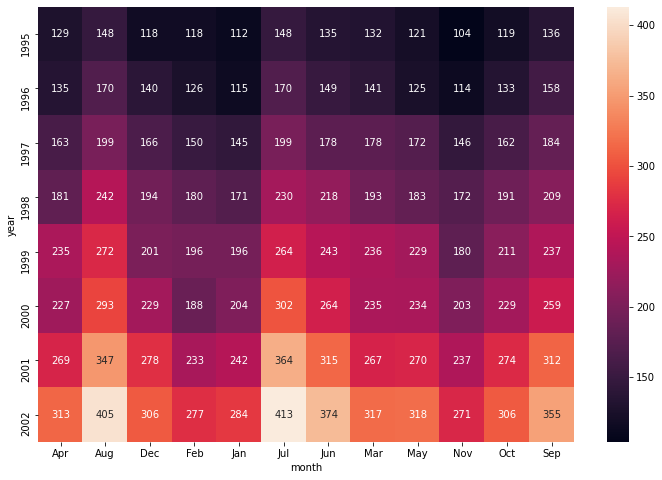

In [161]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

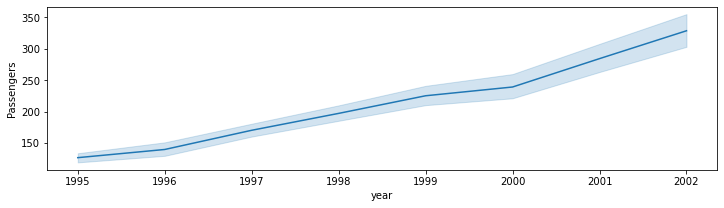

In [162]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=data)

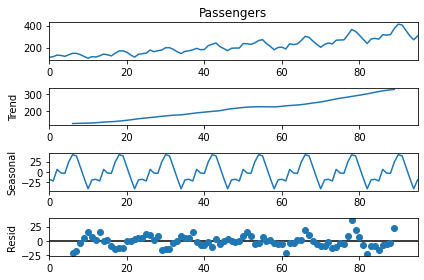

In [163]:
decompose_ts_add = seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show() 

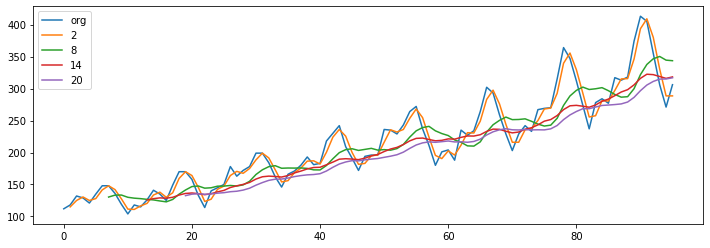

In [164]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,24,6):
    data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

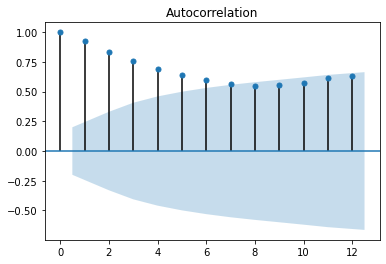

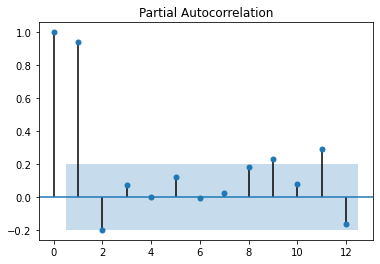

In [165]:
tsa_plots.plot_acf(data.Passengers,lags=12)
tsa_plots.plot_pacf(data.Passengers,lags=12)
plt.show()

### Building different models:

In [166]:
Train = data.head(80)
Test = data.tail(16)

In [167]:
#Linear Model
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_linear))**2)) 

#Exponential
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))

#Quadratic 
Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))

#Additive seasonality 
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))

#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))

#Multiplicative Seasonality
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))

#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))

rmse_data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(rmse_data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,9.469000
4,rmse_add_sea_quad,23.910984
2,rmse_Quad,43.654404
1,rmse_Exp,43.793739
0,rmse_linear,47.542624
3,rmse_add_sea,129.266476
5,rmse_Mult_sea,135.326484


###### Observation: We can see that the rmse value is least for the Multiplicative Additive Seasonality model. We can use it as the final model

In [168]:
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Date,year,log_Passengers
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,0,0,0,0,0,0,0,1995-01-01,1995,4.718499
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,0,0,0,0,0,0,0,1995-02-01,1995,4.770685
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,0,0,0,0,0,0,0,1995-03-01,1995,4.882802
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,0,0,0,0,0,0,0,1995-04-01,1995,4.859812
4,1995-05-01,121,5,25,May,0,0,0,0,1,0,0,0,0,0,0,0,1995-05-01,1995,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,0,0,1,0,0,0,0,2002-08-01,2002,6.003887
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,0,0,0,1,0,0,0,2002-09-01,2002,5.872118
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,0,0,0,0,1,0,0,2002-10-01,2002,5.723585
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,0,0,0,0,0,1,0,2002-11-01,2002,5.602119


In [169]:
model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()

In [170]:
pred_new  = pd.Series(add_sea_Quad.predict(data)) 
pred_new  

0     100.132761
1     100.444544
2     127.184899
3     120.496682
4     119.237037
         ...    
91    356.368332
92    329.618361
93    307.436401
94    287.254440
95    309.572479
Length: 96, dtype: float64

In [172]:
data["forecasted_Passengers"] = pd.Series(pred_new) 

In [173]:
data

,Month,Passengers,t,t_square,month,Jan,Feb,Mar,Apr,May,...,Jul,Aug,Sep,Oct,Nov,Dec,Date,year,log_Passengers,forecasted_Passengers
0,1995-01-01,112,1,1,Jan,1,0,0,0,0,...,0,0,0,0,0,0,1995-01-01,1995,4.718499,100.132761
1,1995-02-01,118,2,4,Feb,0,1,0,0,0,...,0,0,0,0,0,0,1995-02-01,1995,4.770685,100.444544
2,1995-03-01,132,3,9,Mar,0,0,1,0,0,...,0,0,0,0,0,0,1995-03-01,1995,4.882802,127.184899
3,1995-04-01,129,4,16,Apr,0,0,0,1,0,...,0,0,0,0,0,0,1995-04-01,1995,4.859812,120.496682
4,1995-05-01,121,5,25,May,0,0,0,0,1,...,0,0,0,0,0,0,1995-05-01,1995,4.795791,119.237037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,0,0,0,0,0,...,0,1,0,0,0,0,2002-08-01,2002,6.003887,356.368332
92,2002-09-01,355,93,8649,Sep,0,0,0,0,0,...,0,0,1,0,0,0,2002-09-01,2002,5.872118,329.618361
93,2002-10-01,306,94,8836,Oct,0,0,0,0,0,...,0,0,0,1,0,0,2002-10-01,2002,5.723585,307.436401
94,2002-11-01,271,95,9025,Nov,0,0,0,0,0,...,0,0,0,0,1,0,2002-11-01,2002,5.602119,287.254440
